In [1]:
from numpy import expand_dims, zeros, ones, asarray
from numpy.random import randn, randint

from keras.datasets.mnist import load_data
from keras.optimizers import Adam
from keras.models import Model, Sequential

from keras.layers import Input, Dense, Reshape, Flatten, Conv2D, Conv2DTranspose
from keras.layers import LeakyReLU, Dropout, Lambda, Activation

In [2]:
from matplotlib import pyplot as plt
from keras import backend as K
import numpy as np
import math
import matplotlib

# Helper functions

In [3]:
def images(x,y=None, indices='all', columns=12, x_size=1, y_size=1,
                colorbar=False, y_pred=None, cm='binary', norm=None, y_padding=0.35, spines_alpha=1,
                fontsize=20, interpolation='lanczos', ):

    if indices=='all': indices=range(len(x))
    if norm and len(norm) == 2: norm = matplotlib.colors.Normalize(vmin=norm[0], vmax=norm[1])
    draw_labels = (y is not None)
    draw_pred   = (y_pred is not None)
    rows        = math.ceil(len(indices)/columns)
    fig=plt.figure(figsize=(columns*x_size, rows*(y_size+y_padding)))
    n=1
    for i in indices:
        axs=fig.add_subplot(rows, columns, n)
        n+=1
        # ---- Shape is (lx,ly)
        if len(x[i].shape)==2:
            xx=x[i]
        # ---- Shape is (lx,ly,n)
        if len(x[i].shape)==3:
            (lx,ly,lz)=x[i].shape
            if lz==1:
                xx=x[i].reshape(lx,ly)
            else:
                xx=x[i]
        img=axs.imshow(xx,   cmap = cm, norm=norm, interpolation=interpolation)
        axs.spines['right'].set_visible(True)
        axs.spines['left'].set_visible(True)
        axs.spines['top'].set_visible(True)
        axs.spines['bottom'].set_visible(True)
        axs.spines['right'].set_alpha(spines_alpha)
        axs.spines['left'].set_alpha(spines_alpha)
        axs.spines['top'].set_alpha(spines_alpha)
        axs.spines['bottom'].set_alpha(spines_alpha)
        axs.set_yticks([])
        axs.set_xticks([])
        if draw_labels and not draw_pred:
            axs.set_xlabel(y[i],fontsize=fontsize)
        if draw_labels and draw_pred:
            if y[i]!=y_pred[i]:
                axs.set_xlabel(f'{y_pred[i]} ({y[i]})',fontsize=fontsize)
                axs.xaxis.label.set_color('red')
            else:
                axs.set_xlabel(y[i],fontsize=fontsize)
        if colorbar:
            fig.colorbar(img,orientation="vertical", shrink=0.65)
    plt.show()

In [4]:
import itertools
import sklearn

def confusion_matrix(y_true,y_pred,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True,
                          figsize=(10, 8),
                          digit_format='{:0.2f}',):

    cm = sklearn.metrics.confusion_matrix( y_true,y_pred, normalize=None, labels=target_names)

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=90)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, digit_format.format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [5]:
def history(histo, figsize=(8,6),
                 plot={"Accuracy":['sup_acc','val_sup_acc'], 'Loss':['sup_loss', 'val_sup_loss']},
                 save_as='auto'):

    fig_id=0
    for title,curves in plot.items():
        plt.figure(figsize=figsize)
        plt.title(title)
        plt.ylabel(title)
        plt.xlabel('Epoch')
        for c in curves:
            plt.plot(histo[c])
        plt.legend(curves, loc='upper left')
        if save_as=='auto':
            figname='auto'
        else:
            figname=f'{save_as}_{fig_id}'
            fig_id+=1
        #save_fig(figname)
        plt.show()

# Define the generator model

In [6]:
def define_generator(latent_dim):

	in_lat = Input(shape=(latent_dim,))
	#Start with enough dense nodes to be reshaped and ConvTransposed to 28x28x1
	n_nodes = 256 * 7 * 7
	X = Dense(n_nodes)(in_lat)
	X = LeakyReLU(alpha=0.2)(X)
	X = Reshape((7, 7, 256))(X)

	X = Conv2DTranspose(128, (3,3), strides=(2,2), padding='same')(X) #14x14x128
	X = LeakyReLU(alpha=0.2)(X)

	X = Conv2DTranspose(64, (3,3), strides=(1,1), padding='same')(X) #14x14x64
	X = LeakyReLU(alpha=0.2)(X)
	# output
	out_layer = Conv2DTranspose(1, (3,3), strides=(2,2), activation='tanh',
                             padding='same')(X) #28x28x1
	# define model
	model = Model(in_lat, out_layer)
	return model

# gen_model=define_generator(100)
# print(gen_model.summary())

# Define the base discriminator model for sup and unsup discriminators

In [7]:
#This is the base discriminator that supervised and unsupervised are going to share weights from.
def define_discriminator(in_shape=(28,28,1), n_classes=10):
    in_image = Input(shape=in_shape)
    X = Conv2D(32, (3,3), strides=(2,2), padding='same')(in_image)
    X = LeakyReLU(alpha=0.2)(X)

    X = Conv2D(64, (3,3), strides=(2,2), padding='same')(X)
    X = LeakyReLU(alpha=0.2)(X)

    X = Conv2D(128, (3,3), strides=(2,2), padding='same')(X)
    X = LeakyReLU(alpha=0.2)(X)

    X = Flatten()(X)
    X = Dropout(0.4)(X)
    X = Dense(n_classes)(X)

    model = Model(inputs=in_image, outputs=X)

    return model

# Define supervised discriminator

In [8]:
def define_sup_discriminator(disc):
    model=Sequential()
    model.add(disc)
    model.add(Activation('softmax'))
    #use sparse categorical loss so we dont have to convert our Y to categorical
    model.compile(optimizer=Adam(learning_rate=0.0002, beta_1=0.5),
                  loss="sparse_categorical_crossentropy",metrics=['accuracy'])
    return model

# Define unsupervised discriminator

In [9]:
# custom activation function for the unsupervised discriminator
#D(x) = Z(x) / (Z(x) + 1) where Z(x) = sum(exp(l(x))). l(x) is the output from sup discr. prior to softmax
def custom_activation(x):
    Z_x = K.sum(K.exp(x), axis=-1, keepdims=True)
    D_x = Z_x /(Z_x+1)

    return D_x

In [10]:
def define_unsup_discriminator(disc):
    model=Sequential()
    model.add(disc)
    model.add(Lambda(custom_activation))
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5))
    return model

In [11]:
def define_gan(gen_model, disc_unsup):

	disc_unsup.trainable = False # make unsup. discriminator not trainable
	gan_output = disc_unsup(gen_model.output) #Gen. output is the input to disc.
	model = Model(gen_model.input, gan_output)
	model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5))
	return model

# gan_model = define_gan(gen_model, disc_unsup)
# print(gan_model.summary())

In [12]:
# load the images
def load_real_samples(n_classes=10):
    (trainX, trainy), (_, _) = load_data()
    X = expand_dims(trainX, axis=-1)
    X = X.astype('float32')
    X = (X - 127.5) / 127.5  # scale from [0,255] to [-1,1].
    print(X.shape, trainy.shape)
    return [X, trainy]

#data = load_real_samples()

In [13]:
#select subset of the dataset for supervised training
#we pick only 100 samples to be used in supervised training.
#Also, we need to ensure we pick 10 samples per class to ensure a good balance
#of data between classes.
def select_supervised_samples(dataset, n_samples=100, n_classes=10):
  X, y = dataset
  X_list, y_list = list(), list()
  n_per_class = int(n_samples / n_classes) #Number of examples per class.
  for i in range(n_classes):
          X_with_class = X[y == i] # get all images for this class
          ix = randint(0, len(X_with_class), n_per_class) # choose random images for each class
          [X_list.append(X_with_class[j]) for j in ix] # add to list
          [y_list.append(i) for j in ix]
  return asarray(X_list), asarray(y_list) #Returns a list of 2 numpy arrays corresponding to X and Y

In [14]:
# Pick real samples from the dataset.
#Return both images and corresponding labels in addition to y=1 indicating that the images are real.
#we will not use the labels for unsupervised, only used for supervised.
def generate_real_samples(dataset, n_samples):

	images, labels = dataset
	ix = randint(0, images.shape[0], n_samples)
	X, labels = images[ix], labels[ix] #Select random images and corresponding labels
	y = ones((n_samples, 1)) #Label all images as 1 as these are real images. (for the discriminator training)
	return [X, labels], y

In [15]:
# generate latent points, to be used as inputs to the generator.
def generate_latent_points(latent_dim, n_samples):
	z_input = randn(latent_dim * n_samples)
	z_input = z_input.reshape(n_samples, latent_dim) # reshape for input to the network
	return z_input

In [16]:
# Generate fake images using the generator and above latent points as input to it.
#We do not care about labeles so the generator will not know anything about the labels.
def generate_fake_samples(generator, latent_dim, n_samples):

	z_input = generate_latent_points(latent_dim, n_samples)
	fake_images = generator.predict(z_input)
	# create class labels
	y = zeros((n_samples, 1)) #Label all images as 0 as these are fake images. (for the discriminator training)
	return fake_images, y

In [17]:
# report accuracy and save plots & the model periodically.
def summarize_performance(step, gen_model, disc_sup, latent_dim, dataset, n_samples=100):
	# Generate fake images
	X, _ = generate_fake_samples(gen_model, latent_dim, n_samples)

	X = (X + 1) / 2.0 # scale to [0,1] for plotting
	# plot images
	for i in range(100):
		plt.subplot(10, 10, 1 + i)
		plt.axis('off')
		plt.imshow(X[i, :, :, 0], cmap='gray_r')
	# save plot to drive
	filename1 = 'generated_plot_%04d.png' % (step+1)
	plt.savefig(filename1)
	plt.close()

	# evaluate the discriminator
	X, y = dataset
	_, acc = disc_sup.evaluate(X, y, verbose=0)
	print('Discriminator Accuracy: %.3f%%' % (acc * 100))
	# save the generator model
	filename2 = 'gen_model_%04d.h5' % (step+1)
	gen_model.save(filename2)
	# save the Discriminator (classifier) model
	filename3 = 'disc_sup_%04d.h5' % (step+1)
	disc_sup.save(filename3)
	print('>Saved: %s, %s, and %s' % (filename1, filename2, filename3))

In [18]:
train_history = {"sup_loss": list(), "sup_acc": list(), "val_sup_loss": list(), "val_sup_acc": list(), "d_loss_real": list(), "d_loss_fake": list(), "gan_loss": list(),}

In [19]:
# train the generator and discriminator
def train(gen_model, disc_unsup, disc_sup, gan_model, dataset,  testX, testy, latent_dim, n_epochs=20, n_batch=100):

  # select supervised dataset for training.
  #we are not using all 60k images, just a subset (100 images, 10 per class. )
	X_sup, y_sup = select_supervised_samples(dataset)
	#print(X_sup.shape, y_sup.shape)

	bat_per_epo = int(dataset[0].shape[0] / n_batch)
	# iterations
	n_steps = bat_per_epo * n_epochs

	half_batch = int(n_batch / 2)
	print('n_epochs=%d, n_batch=%d, 1/2=%d, b/e=%d, steps=%d' % (n_epochs,
                                                              n_batch, half_batch,
                                                              bat_per_epo, n_steps))
  #  enumerate epochs
	for i in range(n_steps):
		# update supervised discriminator (disc_sup) on real samples.
        #we use real labels to train as this is supervised.
        #This is the discriminator we really care about at the end.
        #Also, this is a multiclass classifier, not binary. Therefore, our y values
        #will be the real class labels for MNIST. (NOT 1 or 0 indicating real or fake.)
		[Xsup_real, ysup_real], _ = generate_real_samples([X_sup, y_sup], half_batch)
		sup_loss, sup_acc = disc_sup.train_on_batch(Xsup_real, ysup_real)


		# update unsupervised discriminator (disc_unsup) - just like in our regular GAN.
        #we will not train on labels as this is unsupervised, just binary as in our regular GAN.
        #The y_real below indicates 1s telling the discriminator that these images are real.
        #do not confuse this with class labels.
        #We will discard this discriminator at the end.
		[X_real, _], y_real = generate_real_samples(dataset, half_batch) #
		d_loss_real = disc_unsup.train_on_batch(X_real, y_real)

        #Now train on fake.
		X_fake, y_fake = generate_fake_samples(gen_model, latent_dim, half_batch)
		d_loss_fake = disc_unsup.train_on_batch(X_fake, y_fake)


		# update generator (gen) - like we do in regular GAN.
        #We can discard this model at the end as our primary goal is to train a multiclass classifier (sup. disc.)
		X_gan, y_gan = generate_latent_points(latent_dim, n_batch), ones((n_batch, 1))
		gan_loss = gan_model.train_on_batch(X_gan, y_gan)


		# summarize loss on this batch
		print('>%d, c[%.3f,%.3f], d[%.3f,%.3f], g[%.3f]' % (i+1, sup_loss, sup_acc, d_loss_real, d_loss_fake, gan_loss))
		# evaluate the model performance periodically
		if (i+1) % (bat_per_epo * 1) == 0:
			train_history["sup_loss"].append(sup_loss)
			train_history["sup_acc"].append(sup_acc)
			train_history["d_loss_real"].append(d_loss_real)
			train_history["d_loss_fake"].append(d_loss_fake)
			train_history["gan_loss"].append(gan_loss)
			val_sup_loss, val_sup_acc = disc_sup.evaluate(testX, testy, verbose=0)
			train_history["val_sup_loss"].append(val_sup_loss)
			train_history["val_sup_acc"].append(val_sup_acc)
			summarize_performance(i, gen_model, disc_sup, latent_dim, dataset)
	return

In [20]:
dataset = load_real_samples() #Define the dataset by loading real samples. (This will be a list of 2 numpy arrays, X and y)
# load the dataset
(_, _), (testX, testy) = load_data()
# expand to 3d, e.g. add channels
testX = expand_dims(testX, axis=-1)

# convert from ints to floats
testX = testX.astype('float32')

# scale from [0,255] to [-1,1]
testX = (testX - 127.5) / 127.5

11490434/11490434 [==============================] - 0s 0us/step
(60000, 28, 28, 1) (60000,)


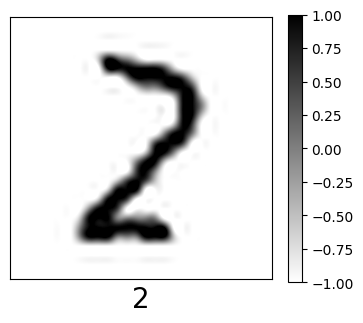

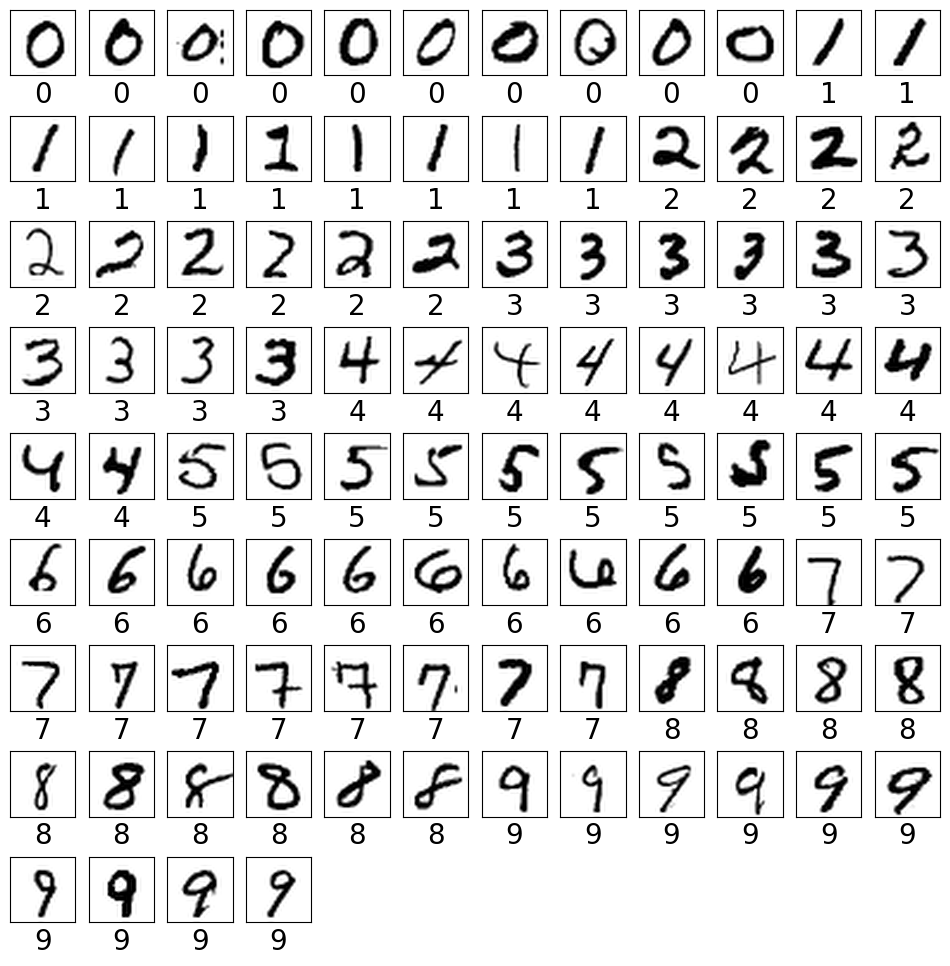

In [21]:
x, y = select_supervised_samples(dataset)
images(x, y, [27],  x_size=5,y_size=5, colorbar=True,)
images(x, y, range(0,len(x)), columns=12,)

# TRAIN

In [22]:
latent_dim = 100

# create the discriminator models
disc=define_discriminator() #Bare discriminator model...
disc_sup=define_sup_discriminator(disc) #Supervised discriminator model
disc_unsup=define_unsup_discriminator(disc) #Unsupervised discriminator model.

gen_model = define_generator(latent_dim) #Generator
gan_model = define_gan(gen_model, disc_unsup) #GAN

# train the model
train(gen_model, disc_unsup, disc_sup, gan_model, dataset, testX, testy, latent_dim, n_epochs=20, n_batch=100)

n_epochs=20, n_batch=100, 1/2=50, b/e=600, steps=12000
2/2 [==============================] - 0s 88ms/step
>1, c[2.314,0.100], d[0.099,2.398], g[0.095]
2/2 [==============================] - 0s 6ms/step
>2, c[2.311,0.060], d[0.096,2.398], g[0.095]
2/2 [==============================] - 0s 4ms/step
>3, c[2.302,0.080], d[0.093,2.397], g[0.095]
2/2 [==============================] - 0s 5ms/step
>4, c[2.317,0.100], d[0.091,2.396], g[0.096]
2/2 [==============================] - 0s 5ms/step
>5, c[2.286,0.240], d[0.089,2.395], g[0.096]
2/2 [==============================] - 0s 4ms/step
>6, c[2.277,0.200], d[0.087,2.394], g[0.096]
2/2 [==============================] - 0s 4ms/step
>7, c[2.282,0.200], d[0.085,2.393], g[0.096]
2/2 [==============================] - 0s 4ms/step
>8, c[2.275,0.160], d[0.082,2.392], g[0.096]
2/2 [==============================] - 0s 5ms/step
>9, c[2.267,0.140], d[0.080,2.391], g[0.096]
2/2 [==============================] - 0s 5ms/step
>10, c[2.255,0.300], d[0.078,

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Discriminator Accuracy: 78.025%
>Saved: generated_plot_0600.png, gen_model_0600.h5, and disc_sup_0600.h5
2/2 [==============================] - 0s 4ms/step
>601, c[0.072,1.000], d[0.915,0.827], g[1.221]
2/2 [==============================] - 0s 5ms/step
>602, c[0.099,0.980], d[0.822,0.729], g[1.053]
2/2 [==============================] - 0s 5ms/step
>603, c[0.084,1.000], d[0.714,0.978], g[1.166]
2/2 [==============================] - 0s 6ms/step
>604, c[0.055,1.000], d[0.879,0.883], g[1.053]
2/2 [==============================] - 0s 5ms/step
>605, c[0.086,1.000], d[0.778,0.860], g[1.154]
2/2 [==============================] - 0s 3ms/step
>606, c[0.111,0.980], d[0.964,0.970], g[1.088]
2/2 [==============================] - 0s 5ms/step
>607, c[0.073,1.000], d[0.805,0.890], g[1.113]
2/2 [==============================] - 0s 3ms/step
>608, c[0.040,1.000], d[0.994,0.980], g[1.132]
2/2 [==============================] - 0s 5ms/step
>609, c[0.085,1.000], d[0.814,0.934], g[1.189]
2/2 [========

Discriminator Accuracy: 84.407%
>Saved: generated_plot_1200.png, gen_model_1200.h5, and disc_sup_1200.h5
2/2 [==============================] - 0s 4ms/step
>1201, c[0.025,1.000], d[1.060,0.571], g[1.309]
2/2 [==============================] - 0s 13ms/step
>1202, c[0.018,1.000], d[0.731,0.587], g[1.198]
2/2 [==============================] - 0s 4ms/step
>1203, c[0.035,1.000], d[0.800,1.071], g[1.101]
2/2 [==============================] - 0s 4ms/step
>1204, c[0.033,1.000], d[0.829,0.935], g[1.101]
2/2 [==============================] - 0s 7ms/step
>1205, c[0.035,1.000], d[0.625,0.929], g[1.233]
2/2 [==============================] - 0s 4ms/step
>1206, c[0.037,1.000], d[0.725,0.702], g[1.327]
2/2 [==============================] - 0s 6ms/step
>1207, c[0.015,1.000], d[1.047,0.842], g[1.123]
2/2 [==============================] - 0s 5ms/step
>1208, c[0.031,1.000], d[0.944,0.663], g[1.152]
2/2 [==============================] - 0s 7ms/step
>1209, c[0.033,1.000], d[0.969,1.010], g[1.040]
2/2

Discriminator Accuracy: 89.152%
>Saved: generated_plot_1800.png, gen_model_1800.h5, and disc_sup_1800.h5
2/2 [==============================] - 0s 8ms/step
>1801, c[0.024,1.000], d[0.697,0.758], g[1.054]
2/2 [==============================] - 0s 7ms/step
>1802, c[0.015,1.000], d[0.737,0.911], g[1.120]
2/2 [==============================] - 0s 6ms/step
>1803, c[0.034,1.000], d[0.865,0.743], g[1.135]
2/2 [==============================] - 0s 4ms/step
>1804, c[0.029,1.000], d[0.748,0.866], g[1.238]
2/2 [==============================] - 0s 6ms/step
>1805, c[0.019,1.000], d[0.805,0.931], g[1.200]
2/2 [==============================] - 0s 5ms/step
>1806, c[0.015,1.000], d[0.718,0.835], g[1.450]
2/2 [==============================] - 0s 6ms/step
>1807, c[0.010,1.000], d[0.697,0.820], g[1.382]
2/2 [==============================] - 0s 3ms/step
>1808, c[0.030,1.000], d[0.725,0.690], g[1.172]
2/2 [==============================] - 0s 7ms/step
>1809, c[0.013,1.000], d[1.203,0.834], g[1.348]
2/2 

Discriminator Accuracy: 91.440%
>Saved: generated_plot_2400.png, gen_model_2400.h5, and disc_sup_2400.h5
2/2 [==============================] - 0s 4ms/step
>2401, c[0.011,1.000], d[0.864,0.638], g[1.185]
2/2 [==============================] - 0s 4ms/step
>2402, c[0.017,1.000], d[0.426,0.847], g[1.271]
2/2 [==============================] - 0s 6ms/step
>2403, c[0.011,1.000], d[0.714,0.889], g[1.174]
2/2 [==============================] - 0s 11ms/step
>2404, c[0.014,1.000], d[0.799,0.622], g[1.232]
2/2 [==============================] - 0s 4ms/step
>2405, c[0.013,1.000], d[0.823,0.699], g[1.305]
2/2 [==============================] - 0s 4ms/step
>2406, c[0.010,1.000], d[0.809,0.573], g[1.139]
2/2 [==============================] - 0s 8ms/step
>2407, c[0.015,1.000], d[0.820,0.709], g[1.175]
2/2 [==============================] - 0s 4ms/step
>2408, c[0.020,1.000], d[0.854,0.741], g[1.042]
2/2 [==============================] - 0s 5ms/step
>2409, c[0.007,1.000], d[0.769,0.667], g[1.093]
2/2

Discriminator Accuracy: 91.688%
>Saved: generated_plot_3000.png, gen_model_3000.h5, and disc_sup_3000.h5
2/2 [==============================] - 0s 6ms/step
>3001, c[0.007,1.000], d[0.952,0.631], g[1.215]
2/2 [==============================] - 0s 5ms/step
>3002, c[0.006,1.000], d[0.679,0.751], g[1.123]
2/2 [==============================] - 0s 4ms/step
>3003, c[0.006,1.000], d[0.700,0.915], g[1.191]
2/2 [==============================] - 0s 9ms/step
>3004, c[0.005,1.000], d[0.627,0.823], g[1.117]
2/2 [==============================] - 0s 4ms/step
>3005, c[0.006,1.000], d[0.693,0.666], g[1.321]
2/2 [==============================] - 0s 5ms/step
>3006, c[0.008,1.000], d[0.904,0.671], g[1.201]
2/2 [==============================] - 0s 4ms/step
>3007, c[0.020,1.000], d[0.687,0.786], g[1.116]
2/2 [==============================] - 0s 4ms/step
>3008, c[0.015,1.000], d[0.824,1.010], g[1.172]
2/2 [==============================] - 0s 7ms/step
>3009, c[0.008,1.000], d[0.644,0.718], g[1.323]
2/2 

Discriminator Accuracy: 93.137%
>Saved: generated_plot_3600.png, gen_model_3600.h5, and disc_sup_3600.h5
2/2 [==============================] - 0s 8ms/step
>3601, c[0.007,1.000], d[0.685,0.695], g[1.380]
2/2 [==============================] - 0s 6ms/step
>3602, c[0.008,1.000], d[0.796,0.692], g[1.318]
2/2 [==============================] - 0s 3ms/step
>3603, c[0.010,1.000], d[0.698,0.576], g[1.129]
2/2 [==============================] - 0s 8ms/step
>3604, c[0.004,1.000], d[0.721,1.075], g[1.365]
2/2 [==============================] - 0s 8ms/step
>3605, c[0.007,1.000], d[0.836,0.859], g[1.196]
2/2 [==============================] - 0s 6ms/step
>3606, c[0.008,1.000], d[0.799,0.751], g[1.375]
2/2 [==============================] - 0s 4ms/step
>3607, c[0.006,1.000], d[0.719,0.754], g[1.244]
2/2 [==============================] - 0s 4ms/step
>3608, c[0.005,1.000], d[0.583,0.650], g[1.128]
2/2 [==============================] - 0s 9ms/step
>3609, c[0.004,1.000], d[0.985,0.697], g[1.244]
2/2 

Discriminator Accuracy: 93.545%
>Saved: generated_plot_4200.png, gen_model_4200.h5, and disc_sup_4200.h5
2/2 [==============================] - 0s 3ms/step
>4201, c[0.011,1.000], d[0.705,0.721], g[1.277]
2/2 [==============================] - 0s 10ms/step
>4202, c[0.004,1.000], d[0.999,0.885], g[1.210]
2/2 [==============================] - 0s 4ms/step
>4203, c[0.003,1.000], d[0.675,0.762], g[1.374]
2/2 [==============================] - 0s 9ms/step
>4204, c[0.004,1.000], d[0.815,0.960], g[1.177]
2/2 [==============================] - 0s 3ms/step
>4205, c[0.009,1.000], d[0.716,0.720], g[1.144]
2/2 [==============================] - 0s 9ms/step
>4206, c[0.003,1.000], d[0.841,0.620], g[1.245]
2/2 [==============================] - 0s 4ms/step
>4207, c[0.002,1.000], d[0.700,0.642], g[1.192]
2/2 [==============================] - 0s 5ms/step
>4208, c[0.003,1.000], d[0.708,0.740], g[1.157]
2/2 [==============================] - 0s 5ms/step
>4209, c[0.005,1.000], d[0.517,0.812], g[1.248]
2/2

Discriminator Accuracy: 93.662%
>Saved: generated_plot_4800.png, gen_model_4800.h5, and disc_sup_4800.h5
2/2 [==============================] - 0s 7ms/step
>4801, c[0.005,1.000], d[0.728,0.749], g[1.318]
2/2 [==============================] - 0s 5ms/step
>4802, c[0.008,1.000], d[0.942,0.597], g[1.246]
2/2 [==============================] - 0s 4ms/step
>4803, c[0.009,1.000], d[0.861,0.869], g[1.178]
2/2 [==============================] - 0s 5ms/step
>4804, c[0.011,1.000], d[0.701,0.899], g[1.232]
2/2 [==============================] - 0s 4ms/step
>4805, c[0.014,1.000], d[0.819,0.667], g[1.382]
2/2 [==============================] - 0s 9ms/step
>4806, c[0.005,1.000], d[0.826,0.902], g[1.143]
2/2 [==============================] - 0s 5ms/step
>4807, c[0.004,1.000], d[1.075,0.861], g[1.067]
2/2 [==============================] - 0s 10ms/step
>4808, c[0.003,1.000], d[0.568,0.813], g[1.175]
2/2 [==============================] - 0s 5ms/step
>4809, c[0.003,1.000], d[0.884,0.766], g[1.215]
2/2

Discriminator Accuracy: 93.440%
>Saved: generated_plot_5400.png, gen_model_5400.h5, and disc_sup_5400.h5
2/2 [==============================] - 0s 3ms/step
>5401, c[0.003,1.000], d[1.092,0.744], g[1.389]
2/2 [==============================] - 0s 4ms/step
>5402, c[0.002,1.000], d[0.720,0.951], g[1.282]
2/2 [==============================] - 0s 6ms/step
>5403, c[0.007,1.000], d[0.829,0.640], g[1.360]
2/2 [==============================] - 0s 4ms/step
>5404, c[0.004,1.000], d[0.994,0.870], g[1.062]
2/2 [==============================] - 0s 11ms/step
>5405, c[0.005,1.000], d[0.821,0.770], g[1.111]
2/2 [==============================] - 0s 4ms/step
>5406, c[0.002,1.000], d[0.573,0.955], g[1.193]
2/2 [==============================] - 0s 3ms/step
>5407, c[0.002,1.000], d[0.583,0.663], g[1.372]
2/2 [==============================] - 0s 9ms/step
>5408, c[0.003,1.000], d[0.626,0.640], g[1.157]
2/2 [==============================] - 0s 11ms/step
>5409, c[0.002,1.000], d[0.767,0.938], g[1.282]
2/

Discriminator Accuracy: 94.135%
>Saved: generated_plot_6000.png, gen_model_6000.h5, and disc_sup_6000.h5
2/2 [==============================] - 0s 4ms/step
>6001, c[0.003,1.000], d[0.747,0.536], g[1.305]
2/2 [==============================] - 0s 3ms/step
>6002, c[0.004,1.000], d[0.837,0.531], g[1.305]
2/2 [==============================] - 0s 3ms/step
>6003, c[0.002,1.000], d[0.747,0.818], g[1.383]
2/2 [==============================] - 0s 9ms/step
>6004, c[0.001,1.000], d[0.818,0.775], g[1.431]
2/2 [==============================] - 0s 11ms/step
>6005, c[0.009,1.000], d[0.768,0.839], g[1.146]
2/2 [==============================] - 0s 4ms/step
>6006, c[0.003,1.000], d[0.598,0.813], g[1.296]
2/2 [==============================] - 0s 3ms/step
>6007, c[0.006,1.000], d[0.492,0.893], g[1.163]
2/2 [==============================] - 0s 5ms/step
>6008, c[0.004,1.000], d[0.680,0.707], g[1.235]
2/2 [==============================] - 0s 11ms/step
>6009, c[0.011,1.000], d[0.564,0.734], g[1.288]
2/

Discriminator Accuracy: 94.267%
>Saved: generated_plot_6600.png, gen_model_6600.h5, and disc_sup_6600.h5
2/2 [==============================] - 0s 12ms/step
>6601, c[0.003,1.000], d[0.727,0.745], g[1.046]
2/2 [==============================] - 0s 9ms/step
>6602, c[0.002,1.000], d[0.892,1.064], g[1.234]
2/2 [==============================] - 0s 12ms/step
>6603, c[0.022,0.980], d[0.805,0.920], g[1.137]
2/2 [==============================] - 0s 5ms/step
>6604, c[0.003,1.000], d[0.722,0.954], g[1.223]
2/2 [==============================] - 0s 11ms/step
>6605, c[0.001,1.000], d[0.655,0.703], g[1.252]
2/2 [==============================] - 0s 4ms/step
>6606, c[0.002,1.000], d[0.745,0.633], g[1.329]
2/2 [==============================] - 0s 5ms/step
>6607, c[0.004,1.000], d[0.717,0.589], g[1.339]
2/2 [==============================] - 0s 6ms/step
>6608, c[0.004,1.000], d[0.813,0.532], g[1.174]
2/2 [==============================] - 0s 5ms/step
>6609, c[0.004,1.000], d[0.773,0.752], g[1.198]
2

Discriminator Accuracy: 94.143%
>Saved: generated_plot_7200.png, gen_model_7200.h5, and disc_sup_7200.h5
2/2 [==============================] - 0s 7ms/step
>7201, c[0.001,1.000], d[0.825,0.791], g[1.253]
2/2 [==============================] - 0s 6ms/step
>7202, c[0.002,1.000], d[0.903,0.807], g[1.045]
2/2 [==============================] - 0s 4ms/step
>7203, c[0.005,1.000], d[0.558,0.568], g[1.124]
2/2 [==============================] - 0s 4ms/step
>7204, c[0.002,1.000], d[0.668,0.648], g[1.126]
2/2 [==============================] - 0s 4ms/step
>7205, c[0.003,1.000], d[0.638,0.866], g[1.194]
2/2 [==============================] - 0s 14ms/step
>7206, c[0.004,1.000], d[0.714,0.895], g[1.119]
2/2 [==============================] - 0s 10ms/step
>7207, c[0.008,1.000], d[0.645,0.882], g[1.229]
2/2 [==============================] - 0s 11ms/step
>7208, c[0.004,1.000], d[0.633,0.795], g[1.200]
2/2 [==============================] - 0s 5ms/step
>7209, c[0.002,1.000], d[0.804,0.836], g[1.251]
2

Discriminator Accuracy: 94.113%
>Saved: generated_plot_7800.png, gen_model_7800.h5, and disc_sup_7800.h5
2/2 [==============================] - 0s 5ms/step
>7801, c[0.001,1.000], d[0.661,0.823], g[1.072]
2/2 [==============================] - 0s 3ms/step
>7802, c[0.001,1.000], d[0.633,0.799], g[1.073]
2/2 [==============================] - 0s 7ms/step
>7803, c[0.001,1.000], d[0.838,0.599], g[1.111]
2/2 [==============================] - 0s 4ms/step
>7804, c[0.002,1.000], d[0.615,0.917], g[1.232]
2/2 [==============================] - 0s 4ms/step
>7805, c[0.002,1.000], d[0.533,0.608], g[1.124]
2/2 [==============================] - 0s 5ms/step
>7806, c[0.002,1.000], d[0.724,0.854], g[1.065]
2/2 [==============================] - 0s 4ms/step
>7807, c[0.001,1.000], d[0.749,0.846], g[1.312]
2/2 [==============================] - 0s 6ms/step
>7808, c[0.002,1.000], d[0.842,0.545], g[1.236]
2/2 [==============================] - 0s 11ms/step
>7809, c[0.003,1.000], d[0.706,0.999], g[1.181]
2/2

Discriminator Accuracy: 94.318%
>Saved: generated_plot_8400.png, gen_model_8400.h5, and disc_sup_8400.h5
2/2 [==============================] - 0s 5ms/step
>8401, c[0.003,1.000], d[0.820,0.852], g[1.181]
2/2 [==============================] - 0s 9ms/step
>8402, c[0.001,1.000], d[0.968,0.542], g[1.155]
2/2 [==============================] - 0s 4ms/step
>8403, c[0.001,1.000], d[0.906,0.606], g[1.148]
2/2 [==============================] - 0s 6ms/step
>8404, c[0.002,1.000], d[0.840,0.657], g[1.077]
2/2 [==============================] - 0s 13ms/step
>8405, c[0.001,1.000], d[0.758,0.696], g[1.113]
2/2 [==============================] - 0s 3ms/step
>8406, c[0.001,1.000], d[0.627,0.975], g[1.249]
2/2 [==============================] - 0s 15ms/step
>8407, c[0.001,1.000], d[0.803,0.777], g[1.113]
2/2 [==============================] - 0s 13ms/step
>8408, c[0.001,1.000], d[0.776,0.713], g[1.221]
2/2 [==============================] - 0s 6ms/step
>8409, c[0.001,1.000], d[0.856,1.034], g[1.059]
2

Discriminator Accuracy: 94.438%
>Saved: generated_plot_9000.png, gen_model_9000.h5, and disc_sup_9000.h5
2/2 [==============================] - 0s 11ms/step
>9001, c[0.001,1.000], d[0.627,0.851], g[1.124]
2/2 [==============================] - 0s 9ms/step
>9002, c[0.001,1.000], d[0.833,0.639], g[1.087]
2/2 [==============================] - 0s 11ms/step
>9003, c[0.001,1.000], d[0.609,0.796], g[1.223]
2/2 [==============================] - 0s 10ms/step
>9004, c[0.001,1.000], d[0.802,0.535], g[1.104]
2/2 [==============================] - 0s 15ms/step
>9005, c[0.001,1.000], d[0.767,0.751], g[1.166]
2/2 [==============================] - 0s 4ms/step
>9006, c[0.001,1.000], d[0.751,0.503], g[1.195]
2/2 [==============================] - 0s 5ms/step
>9007, c[0.002,1.000], d[0.656,0.760], g[1.183]
2/2 [==============================] - 0s 11ms/step
>9008, c[0.001,1.000], d[0.680,0.930], g[1.204]
2/2 [==============================] - 0s 4ms/step
>9009, c[0.001,1.000], d[0.697,0.620], g[1.362]

Discriminator Accuracy: 94.598%
>Saved: generated_plot_9600.png, gen_model_9600.h5, and disc_sup_9600.h5
2/2 [==============================] - 0s 7ms/step
>9601, c[0.001,1.000], d[0.837,0.919], g[1.165]
2/2 [==============================] - 0s 7ms/step
>9602, c[0.001,1.000], d[0.821,0.848], g[1.221]
2/2 [==============================] - 0s 7ms/step
>9603, c[0.000,1.000], d[0.567,0.647], g[1.342]
2/2 [==============================] - 0s 4ms/step
>9604, c[0.000,1.000], d[0.940,0.721], g[1.150]
2/2 [==============================] - 0s 4ms/step
>9605, c[0.000,1.000], d[0.682,0.771], g[1.409]
2/2 [==============================] - 0s 6ms/step
>9606, c[0.001,1.000], d[0.794,0.694], g[1.334]
2/2 [==============================] - 0s 6ms/step
>9607, c[0.001,1.000], d[0.908,0.649], g[1.133]
2/2 [==============================] - 0s 3ms/step
>9608, c[0.000,1.000], d[0.941,0.855], g[1.217]
2/2 [==============================] - 0s 12ms/step
>9609, c[0.001,1.000], d[0.761,0.699], g[1.095]
2/2

Discriminator Accuracy: 94.745%
>Saved: generated_plot_10200.png, gen_model_10200.h5, and disc_sup_10200.h5
2/2 [==============================] - 0s 14ms/step
>10201, c[0.001,1.000], d[0.742,0.744], g[1.139]
2/2 [==============================] - 0s 14ms/step
>10202, c[0.001,1.000], d[0.861,0.874], g[1.086]
2/2 [==============================] - 0s 7ms/step
>10203, c[0.001,1.000], d[0.880,1.007], g[1.163]
2/2 [==============================] - 0s 4ms/step
>10204, c[0.001,1.000], d[0.731,0.807], g[1.234]
2/2 [==============================] - 0s 10ms/step
>10205, c[0.000,1.000], d[0.774,0.522], g[1.170]
2/2 [==============================] - 0s 4ms/step
>10206, c[0.001,1.000], d[0.700,0.733], g[1.217]
2/2 [==============================] - 0s 5ms/step
>10207, c[0.000,1.000], d[0.799,1.035], g[1.165]
2/2 [==============================] - 0s 4ms/step
>10208, c[0.001,1.000], d[0.768,0.858], g[1.408]
2/2 [==============================] - 0s 8ms/step
>10209, c[0.001,1.000], d[0.815,0.815]

Discriminator Accuracy: 94.472%
>Saved: generated_plot_10800.png, gen_model_10800.h5, and disc_sup_10800.h5
2/2 [==============================] - 0s 10ms/step
>10801, c[0.001,1.000], d[0.646,0.676], g[1.196]
2/2 [==============================] - 0s 6ms/step
>10802, c[0.001,1.000], d[0.876,0.584], g[1.119]
2/2 [==============================] - 0s 12ms/step
>10803, c[0.001,1.000], d[0.868,1.002], g[1.078]
2/2 [==============================] - 0s 11ms/step
>10804, c[0.000,1.000], d[0.891,0.967], g[1.109]
2/2 [==============================] - 0s 5ms/step
>10805, c[0.001,1.000], d[0.889,0.818], g[1.054]
2/2 [==============================] - 0s 3ms/step
>10806, c[0.006,1.000], d[0.697,1.684], g[1.215]
2/2 [==============================] - 0s 5ms/step
>10807, c[0.001,1.000], d[1.100,1.035], g[1.088]
2/2 [==============================] - 0s 11ms/step
>10808, c[0.001,1.000], d[0.827,0.780], g[1.099]
2/2 [==============================] - 0s 11ms/step
>10809, c[0.000,1.000], d[0.591,0.92

Discriminator Accuracy: 94.593%
>Saved: generated_plot_11400.png, gen_model_11400.h5, and disc_sup_11400.h5
2/2 [==============================] - 0s 4ms/step
>11401, c[0.000,1.000], d[0.729,0.625], g[1.116]
2/2 [==============================] - 0s 6ms/step
>11402, c[0.001,1.000], d[0.777,0.694], g[1.122]
2/2 [==============================] - 0s 4ms/step
>11403, c[0.001,1.000], d[1.034,0.697], g[1.015]
2/2 [==============================] - 0s 4ms/step
>11404, c[0.001,1.000], d[0.749,0.977], g[1.112]
2/2 [==============================] - 0s 6ms/step
>11405, c[0.001,1.000], d[0.760,0.781], g[1.075]
2/2 [==============================] - 0s 14ms/step
>11406, c[0.000,1.000], d[0.835,0.750], g[1.087]
2/2 [==============================] - 0s 12ms/step
>11407, c[0.000,1.000], d[0.800,0.646], g[1.129]
2/2 [==============================] - 0s 4ms/step
>11408, c[0.000,1.000], d[0.567,0.958], g[1.225]
2/2 [==============================] - 0s 4ms/step
>11409, c[0.000,1.000], d[0.609,1.191],

Discriminator Accuracy: 93.960%
>Saved: generated_plot_12000.png, gen_model_12000.h5, and disc_sup_12000.h5


# EVALUATE THE SUPERVISED DISCRIMINATOR ON TEST DATA

In [23]:
# This is the model we want as a classifier.
from keras.models import load_model

# load the model
disc_sup_trained_model = load_model('disc_sup_12000.h5')


# evaluate the model
score = disc_sup_trained_model.evaluate(testX, testy, verbose=0)
print(f'Test loss   : {score[0]:4.4f}')
print(f'Test accuracy   : {score[1]:4.4f}')

# Predicting the Test set results
y_pred_test = disc_sup_trained_model.predict(testX)
prediction_test = np.argmax(y_pred_test, axis=1)

Test loss   : 0.1835
Test accuracy   : 0.9415
313/313 [==============================] - 1s 2ms/step


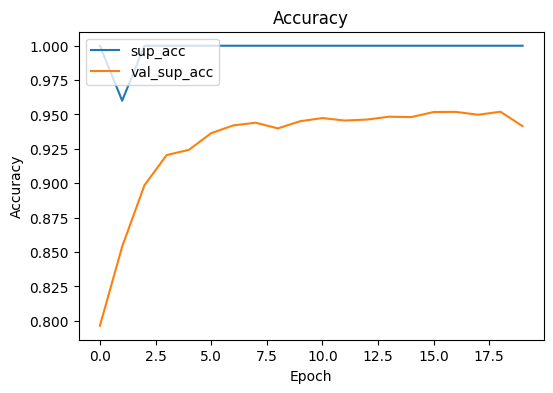

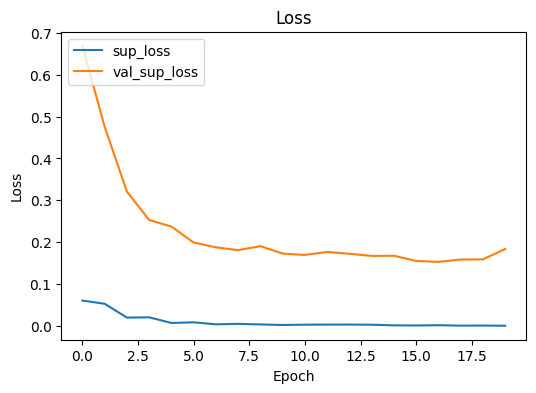

In [24]:
history(train_history, figsize=(6,4))

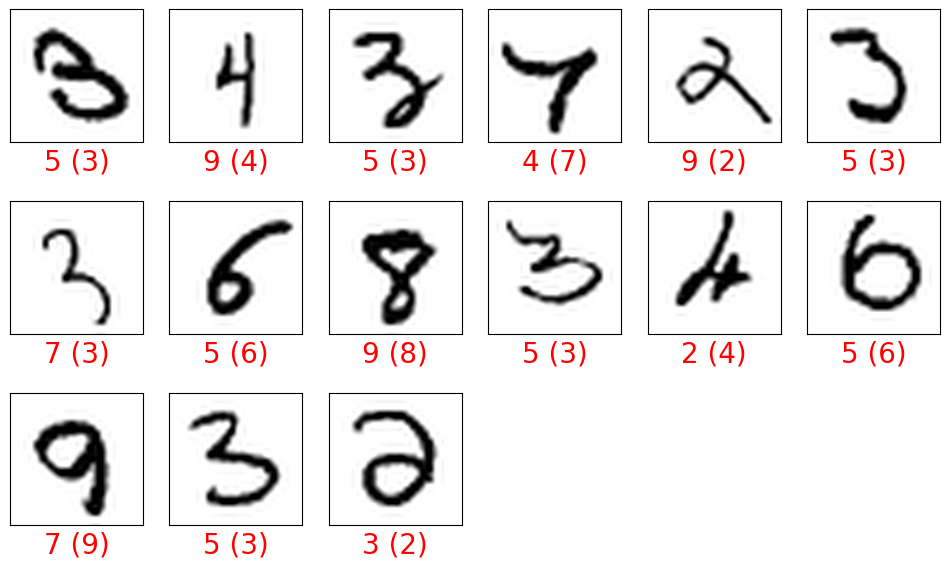

In [25]:
errors=[ i for i in range(len(testX)) if prediction_test[i]!=testy[i] ]
errors=errors[:min(24,len(errors))]
images(testX, testy, errors[:15], columns=6, x_size=2, y_size=2, y_pred=prediction_test)

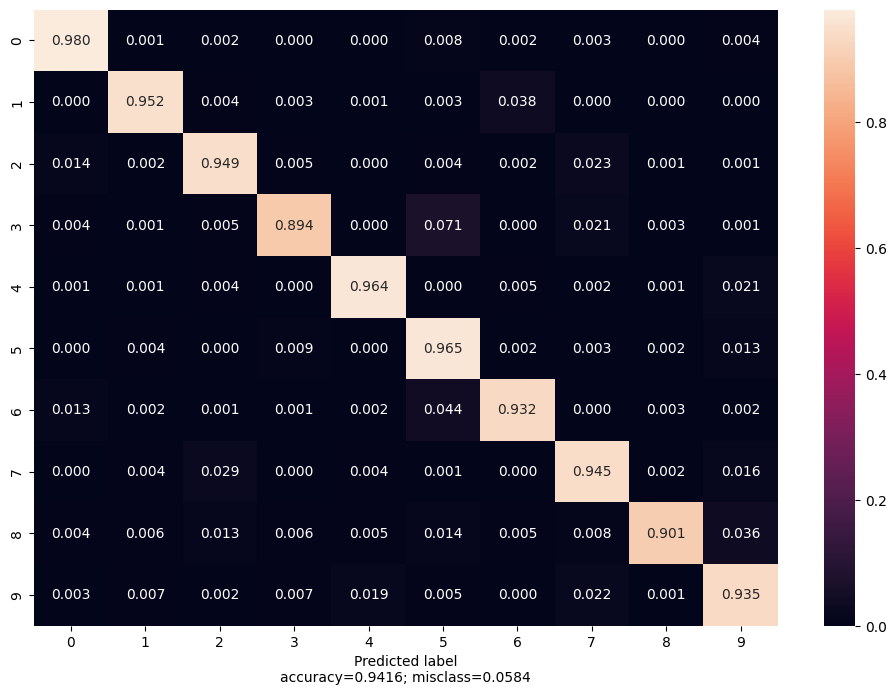

In [26]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(testy, prediction_test)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(12, 8))
sns.heatmap(cm, fmt=".3f", annot=True)
accuracy = np.trace(cm) / float(np.sum(cm))
misclass = 1 - accuracy
plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
plt.show()